**IMPORTING REQUIRED LIBRARIES**

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from copy import deepcopy
import copy
from torch import nn
from tqdm import tqdm
from torch.nn import functional as F
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import random
import PIL.Image as Image
import random
torch.manual_seed(0)

In [ ]:
batch_size = 64
num_task = 5

In [ ]:
class SplitMNIST(datasets.MNIST):
    tasks = {
        0: [0,1],
        1: [2,3],
        2: [4,5],
        3: [6,7],
        4: [8,9],
    }
    
    def __init__(self, root="/vandal/datasets", train=True, task=0, cum=True, binary=False):
        super().__init__(root, train, download=True)
        if not train and cum:
            classes = [i for t in range(task + 1) for i in SplitMNIST.tasks[t]]
        else:
            classes = [i for i in SplitMNIST.tasks[task]]
        self.idx = [i for i in range(len(self.targets)) if self.targets[i] in classes]
        self.transform = transforms.ToTensor()
        self.task = task
        self.cum = cum
        self.binary = binary
        self.train = train
        # print(classes)
        # print(self.targets)
        # print(self.targets[0] in classes)
        # print(self.idx)
    
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, index):
        img, target = self.data[self.idx[index]], self.targets[self.idx[index]]
        img = Image.fromarray(img.numpy(), mode='L')
        img = self.transform(img)
        
        if (self.binary and not self.cum):
            target = target - self.task*2
        # print(target)
        return img, target

for b,(x,y) in enumerate(torch.utils.data.DataLoader(SplitMNIST(train=False,binary=True,cum=False, task=2),
                                                      batch_size=batch_size,
                                                      num_workers=4)):
  print(y)
  print(x.size())
  print(x.dtype)
  break


Extracting /vandal/datasets/SplitMNIST/raw/train-images-idx3-ubyte.gz to /vandal/datasets/SplitMNIST/raw




Extracting /vandal/datasets/SplitMNIST/raw/train-labels-idx1-ubyte.gz to /vandal/datasets/SplitMNIST/raw




Extracting /vandal/datasets/SplitMNIST/raw/t10k-images-idx3-ubyte.gz to /vandal/datasets/SplitMNIST/raw




Extracting /vandal/datasets/SplitMNIST/raw/t10k-labels-idx1-ubyte.gz to /vandal/datasets/SplitMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0])
torch.Size([64, 1, 28, 28])
torch.float32


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
  # ([W-F+2P]/S)+1.
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.conv1 = nn.Sequential(         
        nn.Conv2d(
            in_channels=1,              
            out_channels=16,            
            kernel_size=5,              
            stride=1,                   
            padding=2,                  
        ),                              
        nn.ReLU(),                      
        nn.MaxPool2d(kernel_size=2),    
    )
    self.conv2 = nn.Sequential(         
        nn.Conv2d(16, 32, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )
            # fully connected layer, output 10 classes
    self.out = nn.Linear(32 * 7 * 7, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
    x = x.view(x.size(0), -1)       
    output = self.out(x)
    return output    # return x for visualization

model = NeuralNetwork().to(device)


Using cuda device


**MODIFIED LOADERS**
### TRAIN LOADERS (both non-commulative)
- **Train Loader** = Classes with right labels (for binary classification)
-**Train Loader binary** = Clasess with labels as 0 and 1 (for binary classification)

### TEST LOADERS
- **Test Loader no cum** = No commulative classes from previous tasks and right labels.
- **Test Loader** = *Commulative Classes* from previous task(for eg, task 2 will contain images of 0,1,2,3)
- **Test Loader binary** = Non commulative and labels as 0,1 (for binary classification)






In [ ]:
def get_mnist():
    train_loader = {}
    train_loader_binary = {}
    test_loader = {}
    test_loader_no_cum = {}
    test_loader_binary = {}

    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(SplitMNIST(train=True, task=i),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        train_loader_binary[i] = torch.utils.data.DataLoader(SplitMNIST(train=True,cum=False,binary=True, task=i),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(SplitMNIST(train=False, task=i),
                                                     batch_size=batch_size)
        test_loader_no_cum[i] = torch.utils.data.DataLoader(SplitMNIST(train=False, task=i, cum=False),
                                                     batch_size=batch_size)
        test_loader_binary[i] = torch.utils.data.DataLoader(SplitMNIST(train=False, task=i, cum=False,binary=True),
                                                     batch_size=batch_size)
    return train_loader,train_loader_binary, test_loader, test_loader_no_cum,test_loader_binary

train_loader,train_loader_binary, test_loader, test_loader_no_cum,test_loader_binary = get_mnist()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(train_loader_binary)
print(test_loader_binary)

{0: <torch.utils.data.dataloader.DataLoader object at 0x7f42b3c44850>, 1: <torch.utils.data.dataloader.DataLoader object at 0x7f42b4897190>, 2: <torch.utils.data.dataloader.DataLoader object at 0x7f42b40ddd10>, 3: <torch.utils.data.dataloader.DataLoader object at 0x7f42b3c44a50>, 4: <torch.utils.data.dataloader.DataLoader object at 0x7f42aaed0410>}
{0: <torch.utils.data.dataloader.DataLoader object at 0x7f42b3c78090>, 1: <torch.utils.data.dataloader.DataLoader object at 0x7f42b3c44c50>, 2: <torch.utils.data.dataloader.DataLoader object at 0x7f43112c17d0>, 3: <torch.utils.data.dataloader.DataLoader object at 0x7f42aaed01d0>, 4: <torch.utils.data.dataloader.DataLoader object at 0x7f42aaed0ad0>}


**VISUALISING THE TASK SAMPLES**

USING TRAIN LOADER BINARY AND TEST LOADER BINARY 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


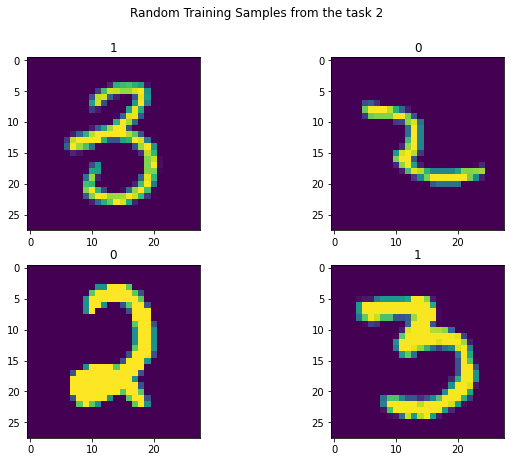

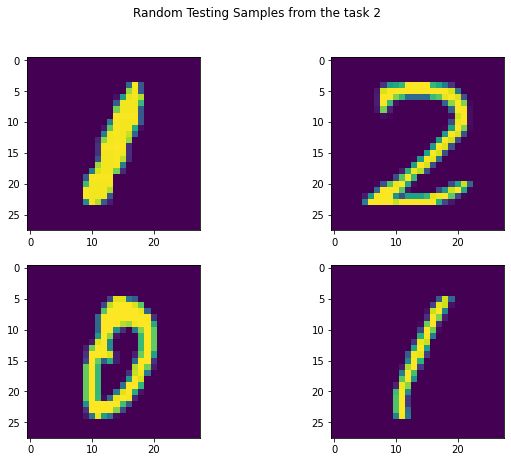

In [ ]:
TASK = 2
fig = plt.figure(figsize=(10, 7))
fig.suptitle(f'Random Training Samples from the task {TASK}')
for batch, (X,Y) in enumerate(train_loader_binary[TASK-1]): #visualising task 1, i.e 0 and 1
  if(batch<4):    
    rdm = random.randint(0,63)
    ax = fig.add_subplot(2, 2, batch+1)
    ax.title.set_text(f'{Y[rdm]}')
    plt.imshow(X[rdm].view(28,28))
# TASK = 3
fig = plt.figure(figsize=(10, 7))
fig.suptitle(f'Random Testing Samples from the task {TASK}')
for batch, (X,Y) in enumerate(test_loader[TASK-1]): #visualising task 1, i.e 0 and 1
  if(batch<4):    
    rdm = random.randint(0,63)
    ax = fig.add_subplot(2, 2, batch+1)
  #  ax.title.set_text(f'{Y[rdm]}')
    plt.imshow(X[rdm].view(28,28))
    # print(Y)

**DEFINING RQD PARAMS**

In [ ]:
loss_fn1 = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer1 = torch.optim.SGD(model.parameters(), lr=learning_rate)

**DEFINING TRAIN FUNCTION**

In [ ]:
def train(dataloader, modelx, loss_fn, optimizerx):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = modelx(X)
        loss = loss_fn(pred, y)
        # best_model_wts = deepcopy(model.state_dict())

        # Backpropagation
        optimizerx.zero_grad()
        loss.backward()
        optimizerx.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

**CATASTROPHIC FORGETTING**

train 2


In [ ]:
def train2(dataloader, modelxs, loss_fn, optimizery):
    size = len(dataloader.dataset)
    for batch2, (X2, y2) in enumerate(dataloader):
        X2, y2 = X2.to(device), y2.to(device)
        
        # Compute prediction error
        pred2 = modelxs(X2)
        loss2 = loss_fn(pred2, y2)
        # best_model_wts = deepcopy(model2.state_dict())

        # Backpropagation
        optimizery.zero_grad()
        loss2.backward()
        optimizery.step()

        if batch2 % 100 == 0:
            loss2, current = loss2.item(), batch2 * len(X)
            print(f"loss: {loss2:>7f}  [{current:>5d}/{size:>5d}]")

**DEFINING TEST FUNCTION**

In [ ]:
def test2(dataloader, modelxs,loss_fn,task_id,cum=0):
    size = len(dataloader.dataset)
    modelxs.eval()
    test_loss2, correct = 0, 0
    with torch.no_grad():
        for X2, y2 in dataloader:
            X2, y2 = X2.to(device), y2.to(device)
            pred2 = modelxs(X2)
            test_loss2 += loss_fn(pred2, y2).item()
            if(cum==0):
              for i in range(len(pred2)):
                if(i not in [2*task_id,2*task_id+1]):
                  pred2[0:,i:i+1] = torch.tensor([[-10]])

            correct += (pred2.argmax(1) == y2).type(torch.float).sum().item()
            
    test_loss2 /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss2:>8f} \n")

**Training a model on a task**

In [ ]:
# No. of epochs for training
epochs = 50

# Select Task ID you want to train on
TASKTRAIN = 1
print("Task: ",TASKTRAIN)

for t in range(epochs):
  print(f"{t+1} of {epochs} epochs")
  train(train_loader[TASKTRAIN-1],model,loss_fn1,optimizer1)

test2(test_loader_binary[(TASKTRAIN-1)],model,loss_fn1,TASKTRAIN-1)



Task:  1
1 of 50 epochs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 0.690233  [    0/12665]
loss: 0.597119  [ 6400/12665]
2 of 50 epochs
loss: 0.489497  [    0/12665]
loss: 0.395469  [ 6400/12665]
3 of 50 epochs
loss: 0.275425  [    0/12665]
loss: 0.220141  [ 6400/12665]
4 of 50 epochs
loss: 0.147928  [    0/12665]
loss: 0.135987  [ 6400/12665]
5 of 50 epochs
loss: 0.094682  [    0/12665]
loss: 0.097816  [ 6400/12665]
6 of 50 epochs
loss: 0.070429  [    0/12665]
loss: 0.077520  [ 6400/12665]
7 of 50 epochs
loss: 0.057796  [    0/12665]
loss: 0.065156  [ 6400/12665]
8 of 50 epochs
loss: 0.050468  [    0/12665]
loss: 0.056828  [ 6400/12665]
9 of 50 epochs
loss: 0.045896  [    0/12665]
loss: 0.050839  [ 6400/12665]
10 of 50 epochs
loss: 0.042894  [    0/12665]
loss: 0.046342  [ 6400/12665]
11 of 50 epochs
loss: 0.040829  [    0/12665]
loss: 0.042851  [ 6400/12665]
12 of 50 epochs
loss: 0.039358  [    0/12665]
loss: 0.040071  [ 6400/12665]
13 of 50 epochs
loss: 0.038264  [    0/12665]
loss: 0.037814  [ 6400/12665]
14 of 50 epochs
loss: 0.037416  [   

**Catastrophic Forgetting**

In [ ]:
for i in range(5):
  test2(test_loader_binary[(i)],model,loss_fn1,i)

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.000085 

Test Error: 
 Accuracy: 50.5%, Avg loss: 0.023582 

Test Error: 
 Accuracy: 52.4%, Avg loss: 0.027931 

Test Error: 
 Accuracy: 48.2%, Avg loss: 0.015860 

Test Error: 
 Accuracy: 49.1%, Avg loss: 0.027039 



In [ ]:
train(train_loader[0],model,loss_fn1,optimizer1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss: 0.021081  [    0/12665]
loss: 0.019449  [ 6400/12665]


In [ ]:

class NeuralNetwork2(nn.Module):
  # ([W-F+2P]/S)+1.
  def __init__(self):
    super(NeuralNetwork2, self).__init__()
    self.conv12 = nn.Sequential(         
        nn.Conv2d(
            in_channels=1,              
            out_channels=16,            
            kernel_size=5,              
            stride=1,                   
            padding=2,                  
        ),                              
        nn.ReLU(),                      
        nn.MaxPool2d(kernel_size=2),    
    )
    self.conv22 = nn.Sequential(         
        nn.Conv2d(16, 32, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )
            # fully connected layer, output 10 classes
    self.out2 = nn.Linear(32 *7  * 7, 4)

  def forward(self, xs):
    xs = self.conv12(xs)
    xs = self.conv22(xs)
    xs = xs.view(xs.size(0), -1)       
    output2 = self.out2(xs)
    return output2   

model2 = NeuralNetwork2().to(device)
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate)


**3,4 params of Last layer of model(model2) initialised with 4 output features**

In [ ]:
model2.out2.weight.data[2:]

tensor([[-0.0218,  0.0019,  0.0135,  ..., -0.0108,  0.0045,  0.0058],
        [-0.0032, -0.0195, -0.0124,  ...,  0.0230,  0.0185,  0.0063]],
       device='cuda:0')

**Last layer of model 1 trained on task 0**

In [ ]:
model.out.weight.data

tensor([[ 0.0083,  0.0242,  0.0280,  ..., -0.0273, -0.0135, -0.0196],
        [ 0.0239,  0.0216, -0.0118,  ...,  0.0202, -0.0076,  0.0104]],
       device='cuda:0')

**Concatenating last 2 params of model2 with 2 params of model**

In [ ]:
newlayerdata = torch.cat((model.out.weight.data,model2.out2.weight.data[2:]),0)

In [ ]:
print(newlayerdata)
# model2.conv12[0].weight = torch.nn.Parameter(model.conv1[0].weight)
# model2.conv22[0].weight = torch.nn.Parameter(model.conv2[0].weight)
model2.out2.weight = torch.nn.Parameter(newlayerdata)

tensor([[ 0.0083,  0.0242,  0.0280,  ..., -0.0273, -0.0135, -0.0196],
        [ 0.0239,  0.0216, -0.0118,  ...,  0.0202, -0.0076,  0.0104],
        [-0.0218,  0.0019,  0.0135,  ..., -0.0108,  0.0045,  0.0058],
        [-0.0032, -0.0195, -0.0124,  ...,  0.0230,  0.0185,  0.0063]],
       device='cuda:0')


In [ ]:
list(model2.state_dict())
model2.conv12[0]
list(model.state_dict())

['conv1.0.weight',
 'conv1.0.bias',
 'conv2.0.weight',
 'conv2.0.bias',
 'out.weight',
 'out.bias']

In [ ]:
for i in range(50):
  train(train_loader[0],model2,loss_fn2,optimizer2)
for i in range(50):
  train(train_loader[1],model2,loss_fn2,optimizer2)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss: 1.352211  [    0/12665]
loss: 1.011318  [ 6400/12665]
loss: 0.675435  [    0/12665]
loss: 0.510533  [ 6400/12665]
loss: 0.321548  [    0/12665]
loss: 0.284691  [ 6400/12665]
loss: 0.189774  [    0/12665]
loss: 0.189511  [ 6400/12665]
loss: 0.133020  [    0/12665]
loss: 0.141906  [ 6400/12665]
loss: 0.103535  [    0/12665]
loss: 0.114284  [ 6400/12665]
loss: 0.086004  [    0/12665]
loss: 0.096478  [ 6400/12665]
loss: 0.074558  [    0/12665]
loss: 0.084057  [ 6400/12665]
loss: 0.066577  [    0/12665]
loss: 0.074898  [ 6400/12665]
loss: 0.060677  [    0/12665]
loss: 0.067853  [ 6400/12665]
loss: 0.056138  [    0/12665]
loss: 0.062299  [ 6400/12665]
loss: 0.052574  [    0/12665]
loss: 0.057909  [ 6400/12665]
loss: 0.049691  [    0/12665]
loss: 0.054299  [ 6400/12665]
loss: 0.047252  [    0/12665]
loss: 0.051159  [ 6400/12665]
loss: 0.045270  [    0/12665]
loss: 0.048438  [ 6400/12665]
loss: 0.043612  [    0/12665]
loss: 0.046047  [ 6400/12665]
loss: 0.042201  [    0/12665]
loss: 0.04

In [ ]:
# task 0
test2(test_loader_no_cum[0],model2,loss_fn2,0,cum=0) 

# task 1
test2(test_loader_no_cum[1],model2,loss_fn2,1,cum=0) 


Test Error: 
 Accuracy: 91.2%, Avg loss: 0.055909 

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.001924 



**Copying first and third layers**

Test Error: 
 Accuracy: 87.4%, Avg loss: 0.018077 

Test Error: 
 Accuracy: 81.6%, Avg loss: 0.013957 

 **Copying only Last layer**

Test Error: 
 Accuracy: 99.3%, Avg loss: 0.021622 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.012751

 **Copying All layers**

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.008059 

Test Error: 
 Accuracy: 48.2%, Avg loss: 0.020329


